In [1]:
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.basemap import Basemap, shiftgrid
import pygrib
import glob
import string
from shapely.geometry import Point, mapping
from fiona import collection


%matplotlib notebook

In [2]:
from osgeo import gdal,gdal_array
import osr

dataTypeformat={1:np.byte,2:np.int32,3:np.int32,4:np.float32,5:np.float32,6:np.byte}
VSType={1:'VS_BOOLEAN',2:'VS_NOMINAL',3:'VS_ORDINAL',4:'VS_SCALAR',5:'VS_DIRECTION',6:'VS_LDD'}

def putmap(filename,var,geo,TYPE,nodata):
     driver=gdal.GetDriverByName('PCRaster')
     varw=var.astype(dataTypeformat[TYPE])
     gtype=gdal_array.NumericTypeCodeToGDALTypeCode(varw.dtype)
     NROWS,NCOLS = var.shape
     VS='PCRASTER_VALUESCALE={}'.format(VSType[TYPE])
     dst_ds=driver.Create(filename,NCOLS,NROWS,1,gtype,[VS])
     proj=osr.SpatialReference()
     proj.ImportFromEPSG(4326)
     dst_ds.SetProjection(proj.ExportToWkt())
     dst_ds.SetGeoTransform(geo)
     dst_ds.GetRasterBand(1).WriteArray(varw)
     dst_ds.GetRasterBand(1).SetNoDataValue(nodata)
     dst_ds.FlushCache()
     dst_ds=None
     return


In [3]:
from gribapi import *
def readgrib(INPUT):
    f = open(INPUT)

#    for t in range(3*time):
#        gid = grib_new_from_file(f,headers_only = True)
    
    for l in range(1):
        gid = grib_new_from_file(f)
        if gid is None: break

        name=grib_get(gid, 'shortName')
        
        ni = grib_get(gid, 'Ni')

        nj =  grib_get(gid, 'Nj')

        lat=grib_get_array(gid,'latitudes')
        lon=grib_get_array(gid,'longitudes')

        dat=grib_get_array(gid,'values')

        grib_release(gid)

    f.close()

    return dat.reshape(nj,ni),lat.reshape(nj,ni),lon.reshape(nj,ni)


In [4]:
def wmap(yyyy=2015,mm=6,dd=3,hh=0,time=1,save=False):
    hh=np.int(hh) # The variables are passed as string and needs to become integer to be used later
    yyyy=np.int(yyyy)
    mm=np.int(mm)
    dd=np.int(dd)
    time=np.int(time)
    # specify date to plot.
    date = datetime.datetime(yyyy,mm,dd,hh)

    # set PATH of the database.
    PATHbase="/mnt/ECMWF/grib_HNMS_WAV/"  # Local mapping location for the above network drive
    PATH=PATHbase+"%04i/%02i/%02i/" % (yyyy,mm,dd)

    dpath=glob.glob(PATH+'*_{:04d}_{:02d}_{:02d}_{:02d}00_{:02d}h.grb'.format(yyyy,mm,dd,hh,time))

    try:
        data = pygrib.open(dpath[0])
    #    data,lats,lons = readgrib(dpath[0]) 
    except:        
        print 'no available data in ', PATH
        return

    # read lats,lons
    latlons=data[1].latlons()
    # reverse latitudes so they go from south to north.
    lats = np.flipud(latlons[0]) # make them increasing
    lons = latlons[1]
 #   lats=np.flipud(lats)
    # get significant height
    sh = data[1].data()[0]
 #   sh = np.ma.masked_equal(data,9999.)
    shi =np.flipud(sh) # make them increasing in lat

    # define projection window
    
    llcrnrlat=lats.min()
    llcrnrlon=lons.min()
    urcrnrlat=lats.max()
    urcrnrlon=lons.max()

    
    # make orthographic basemap.
    m = Basemap(projection='cyl',llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,\
             llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='h')
    # create figure, add axes
    fig1 = plt.figure(figsize=(8,10))
    ax = fig1.add_axes([0.1,0.1,0.8,0.8])
    # set desired contour levels.
    clevs = np.arange(960,1061,5)

    # compute native x,y coordinates of grid.
    x, y = m(lons, lats)
    # define parallels and meridians to draw.
    parallels = np.arange(-90.,90,10.)
    meridians = np.arange(0.,360.,10.)
    # plot SLP contours.
    CS1 = m.contour(x,y,shi,20,linewidths=0.5,colors='k',animated=True)
    CS2 = m.contourf(x,y,shi,20,cmap=plt.cm.RdBu_r,animated=True)
    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5)
    m.drawparallels(parallels)
    m.drawmeridians(meridians)
    # add colorbar
    cb = m.colorbar(CS2,"right", size="5%", pad="2%")
    cb.set_label('m')
    # set plot title
    ax.set_title('Significant height of combined wind waves and swell\n Forecast {} from analysis on {}\n'.format(time,datetime.datetime.strftime(date, '%Y%m%d_%H')) + datetime.datetime.strftime(date+datetime.timedelta(hours=time), '%a %b %d  %H:%M:%S %Z %Y'))
    
    if save :
    #write to geotiff
      TYPE=4
      geo=(lons.min(),data[1].iDirectionIncrementInDegrees,0,lats.max(),0, -data[1].jDirectionIncrementInDegrees)  
      nodata=sh.fill_value
      putmap('tmp/ws.tif',sh,geo,TYPE,nodata)
    
      nstamp=datetime.datetime.strftime(date,'%Y%m%d_%H')  
      plt.savefig('tmp/waves_analysis_on_'+nstamp+'_Forecast_{}'.format(time)+'.png')

    plt.show()

In [5]:
# Define range of file attributes
yy=[2016]
yy=[w for w in map(str,yy )]
mm=np.arange(1,13)
mm=[w for w in map(str,mm )]
dd=np.arange(1,32)
dd=[w for w in map(str,dd )]
hh=[0,12]
hh=[w for w in map(str,hh )]
tt=np.arange(0,51,3)
tt=[w for w in map(str,tt )]



<IPython.core.display.Javascript object>


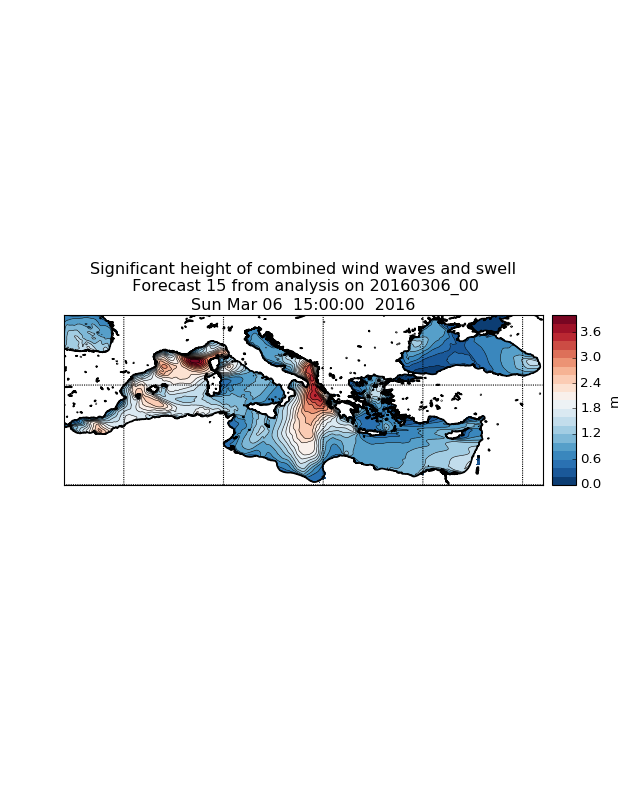

In [6]:
interact_manual(wmap, yyyy=yy, mm=mm, dd=dd, hh=hh, time=tt, save=widgets.Checkbox())